# TimeSeries Exploratory Data Analysis
A better way to analyze timeseries data (and to poke at a causality hypothesis) is to simulate a slider effect. Essentially, we're going to compare how each aspect of Economic Freedom affects GDP per Capita in the short and long term.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', None)

In [2]:
df_base = pd.read_csv("..\Data_Sets\processed\economicData_1995-2022.csv")
#cleaned_data.head(20)

In [3]:
years_delta = [1,2,3,4,5,6,8,10,12,15,20,25]

### TimeSeriesGrowthAnalysis()
To assist us in this journey, let's create the function 'TimeSeriesGrowthAnalysis'. A summary of it:

**Purpose:** This function computes how changes in a predictor variable (like 'Overall Score') relate to changes in a target variable (like 'GDP per capita') over various time ranges.

**Working:** It shifts the time-series data by different time intervals (like 1 year, 2 years, etc) and calculates changes for both the predictor and target. For each time shift, it fits a linear regression model to see how the change in predictor relates to the change in the target.

**Output:** The function outputs regression results (coefficients, intercepts, R^2 scores) for each time shift and an augmented DataFrame (df_withDeltas) that contains computed changes for each time period.

In [4]:
def TimeSeriesGrowthAnalysis(
        df,
        predictor = 'Overall Score',
        target = 'GDP per capita (current USD)',
        quantiledTarget = 'Country Quintile',
        timeField = 'Index Year',
        mergeFields = ['Country Name', 'Index Year'],
        timePeriods_delta = [],
    ):
    '''
    In a nutshell, this function analyzes time-series data using a time-slider-type analysis.
    
    predictor = the (single) variable name you want to analyze. This function doesn't analyze more than one predictor at once.
    target = the dependent variable name we want to predict for.
    quantiledTarget = categorical data to split the data (useful for later visualization)
    timeField = the name of the time column you're using
    mergeFields = a list to define the Primary/Composite Key of the DataSet.
    timePeriods_delta = list of delta ranges to test the data against
    '''
    
    # Initializing Base DataFrame
    cleaned_data = df[[
    mergeFields[0],
    mergeFields[1],
    predictor,
    target,
    quantiledTarget]].dropna()
    
    # Initializing Lists and DF to return
    coefficients = []
    intercepts = []
    r2_scores = []
    df_withDeltas = cleaned_data.copy() #just initializing, for later appending
    
    # Loop over each year delta, compute & store the merged data, and fit a linear regression model
    for delta in timePeriods_delta:
        # Create a shifted dataframe to compute the changes
        shifted_data = cleaned_data.copy()
        shifted_data[timeField] -= delta
        
        merged_data = pd.merge(
            cleaned_data,
            shifted_data,
            on=mergeFields,
            suffixes=('', f'_plus_{delta}'),
            indicator = False,
            how = 'inner'
        )
        
        # If there's no data for this range, go to the next iteration
        if merged_data.shape[0] == 0:
            print(f"No overlapping data for {predictor} with a time delta of {delta}. Appending NaN values for this delta.")

            coefficients.append(np.nan)
            intercepts.append(np.nan)
            r2_scores.append(np.nan)
            continue
                
        
        merged_data.drop(f'{quantiledTarget}_plus_{delta}', axis=1, inplace=True) #line specific to this project

        # Compute the percentage change for predictor and target
        merged_data[f'{target}_change_{delta}']\
            = ((merged_data[f'{target}_plus_{delta}']\
               - merged_data[target])\
               / merged_data[target]) * 100

        merged_data[f'{predictor}_change_{delta}'] = merged_data[f'{predictor}_plus_{delta}'] - merged_data[predictor]
        
        
        
        # Merge results to df_withDeltas based on mergeFields
        df_withDeltas = pd.merge(
            df_withDeltas,
            merged_data[[*mergeFields, f'{predictor}_change_{delta}', f'{target}_change_{delta}']],
            on=mergeFields,
            how='left'
        )        
        
        # -------------------- Model Building & Fitting --------------------
        X = merged_data[f'{predictor}_change_{delta}'].values.reshape(-1, 1)
        y = merged_data[f'{target}_change_{delta}']
        model = LinearRegression().fit(X, y)

        # Store the results
        coefficients.append(model.coef_[0])
        intercepts.append(model.intercept_)
        r2_scores.append(model.score(X, y))


    # Create a results DataFrame
    regression_results = pd.DataFrame({
        'Years Ahead': timePeriods_delta,
        'Coefficient (target to predictor % Change)': coefficients,
        'Intercept': intercepts,
        'R^2 Score': r2_scores
    })
    
    return regression_results, df_withDeltas
 


### PlotTimeSeriesGrowthAnalysis()
To visualize how changes in the predictor variable (like 'Overall Score') correlate with changes in the target variable (like GDP per capita) for different time shifts.


In [5]:
def PlotTimeSeriesGrowthAnalysis(
        df,
        predictor = 'Overall Score',
        target = 'GDP per capita (current USD)',
        quantiledTarget = 'Country Quintile',
        timePeriods_delta = []
    ):

    '''
    In a nutshell, a scatterplot of the data created in the function: TimeSeriesGrowthAnalysis
    See that function for more information on the variables.
    '''

    # Set up the subplots
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))
    axes = axes.ravel()
    
    
    
    # Loop over each period delta, compute the merged data, and plot the data with the regression line
    for i, delta in enumerate(timePeriods_delta):
        
        predictor_column = f'{predictor}_change_{delta}'
        target_column = f'{target}_change_{delta}'

        # Check if the columns exist in the dataframe
        if predictor_column not in df.columns or target_column not in df.columns:
            print(f"No data for {predictor} with a time delta of {delta}. Skipping plot for this delta.")
            continue
        
        # Extract the features and target variable
        X = df[f'{predictor}_change_{delta}']
        y = df[f'{target}_change_{delta}']
        
        hue = df[quantiledTarget]
        quintile_order = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']

        # Plot the data and regression line
        sns.scatterplot(x=X, y=y, hue=hue, ax=axes[i], s=10, palette="RdBu", hue_order=quintile_order)
        sns.regplot(x=X, y=y, ax=axes[i], scatter=False, line_kws={"color": "black"})  # Overlay the regression line
        axes[i].set_title(f'Periods Ahead = {delta}')
        axes[i].set_xlabel(f'Change in {predictor}')
        axes[i].set_ylabel(f'% Change in {target}')
        axes[i].legend(title=quantiledTarget)
        #axes[i].set_ylim(-175, 1500)


    plt.tight_layout()
    plt.show()

## Economic Freedom : Analyzing each aspect on their own
We'll feed our functions with all 12 sub-categories of Heritage's Economic Freedom Index, alongside average aggregations with Overall Score, Rule of Law, Limited Government, Regulatory Efficiency and Open Markets.

In [6]:
df_base['Rule of Law'] = df_base[['Property Rights', 'Government Integrity', 'Judicial Effectiveness']].mean(axis=1)
df_base['Limited Government'] = df_base[['Government Spending', 'Tax Burden', 'Fiscal Health']].mean(axis=1)
df_base['Regulatory Efficiency'] = df_base[['Business Freedom', 'Monetary Freedom', 'Labor Freedom']].mean(axis=1)
df_base['Open Markets'] = df_base[['Financial Freedom', 'Investment Freedom', 'Trade Freedom']].mean(axis=1)

predictors = [
    'Overall Score',
    'Property Rights',
    'Government Integrity',
    'Judicial Effectiveness',
    'Government Spending',
    'Tax Burden',
    'Fiscal Health',
    'Business Freedom',
    'Monetary Freedom',
    'Labor Freedom',
    'Financial Freedom',
    'Investment Freedom',
    'Trade Freedom',
    'Rule of Law',
    'Limited Government',
    'Regulatory Efficiency',
    'Open Markets'
]

In [7]:
predictors = [
    'Overall Score'    
]

## Overall Score: Results


Years Ahead  Coefficient (target to predictor % Change)   Intercept  \
0             1                                    0.103631    5.383974   
1             2                                    0.112778   11.560161   
2             3                                    0.441352   17.916524   
3             4                                    0.899088   25.629207   
4             5                                    1.378233   34.509417   
5             6                                    1.919177   44.124997   
6             8                                    3.003398   66.747978   
7            10                                    4.336623   93.470308   
8            12                                    5.534486  121.047474   
9            15                                    6.497233  161.436682   
10           20                                    8.212138  209.524694   
11           25                                   12.527525  201.767227   

    R^2 Score  
0    0.000251  
1    0.000214  
2    0.002389  
3    0.007338  
4    0.012880  
5    0.018448  
6    0.027835  
7    0.038682  
8    0.053471  
9    0.065956  
10   0.113952  
11   0.216486

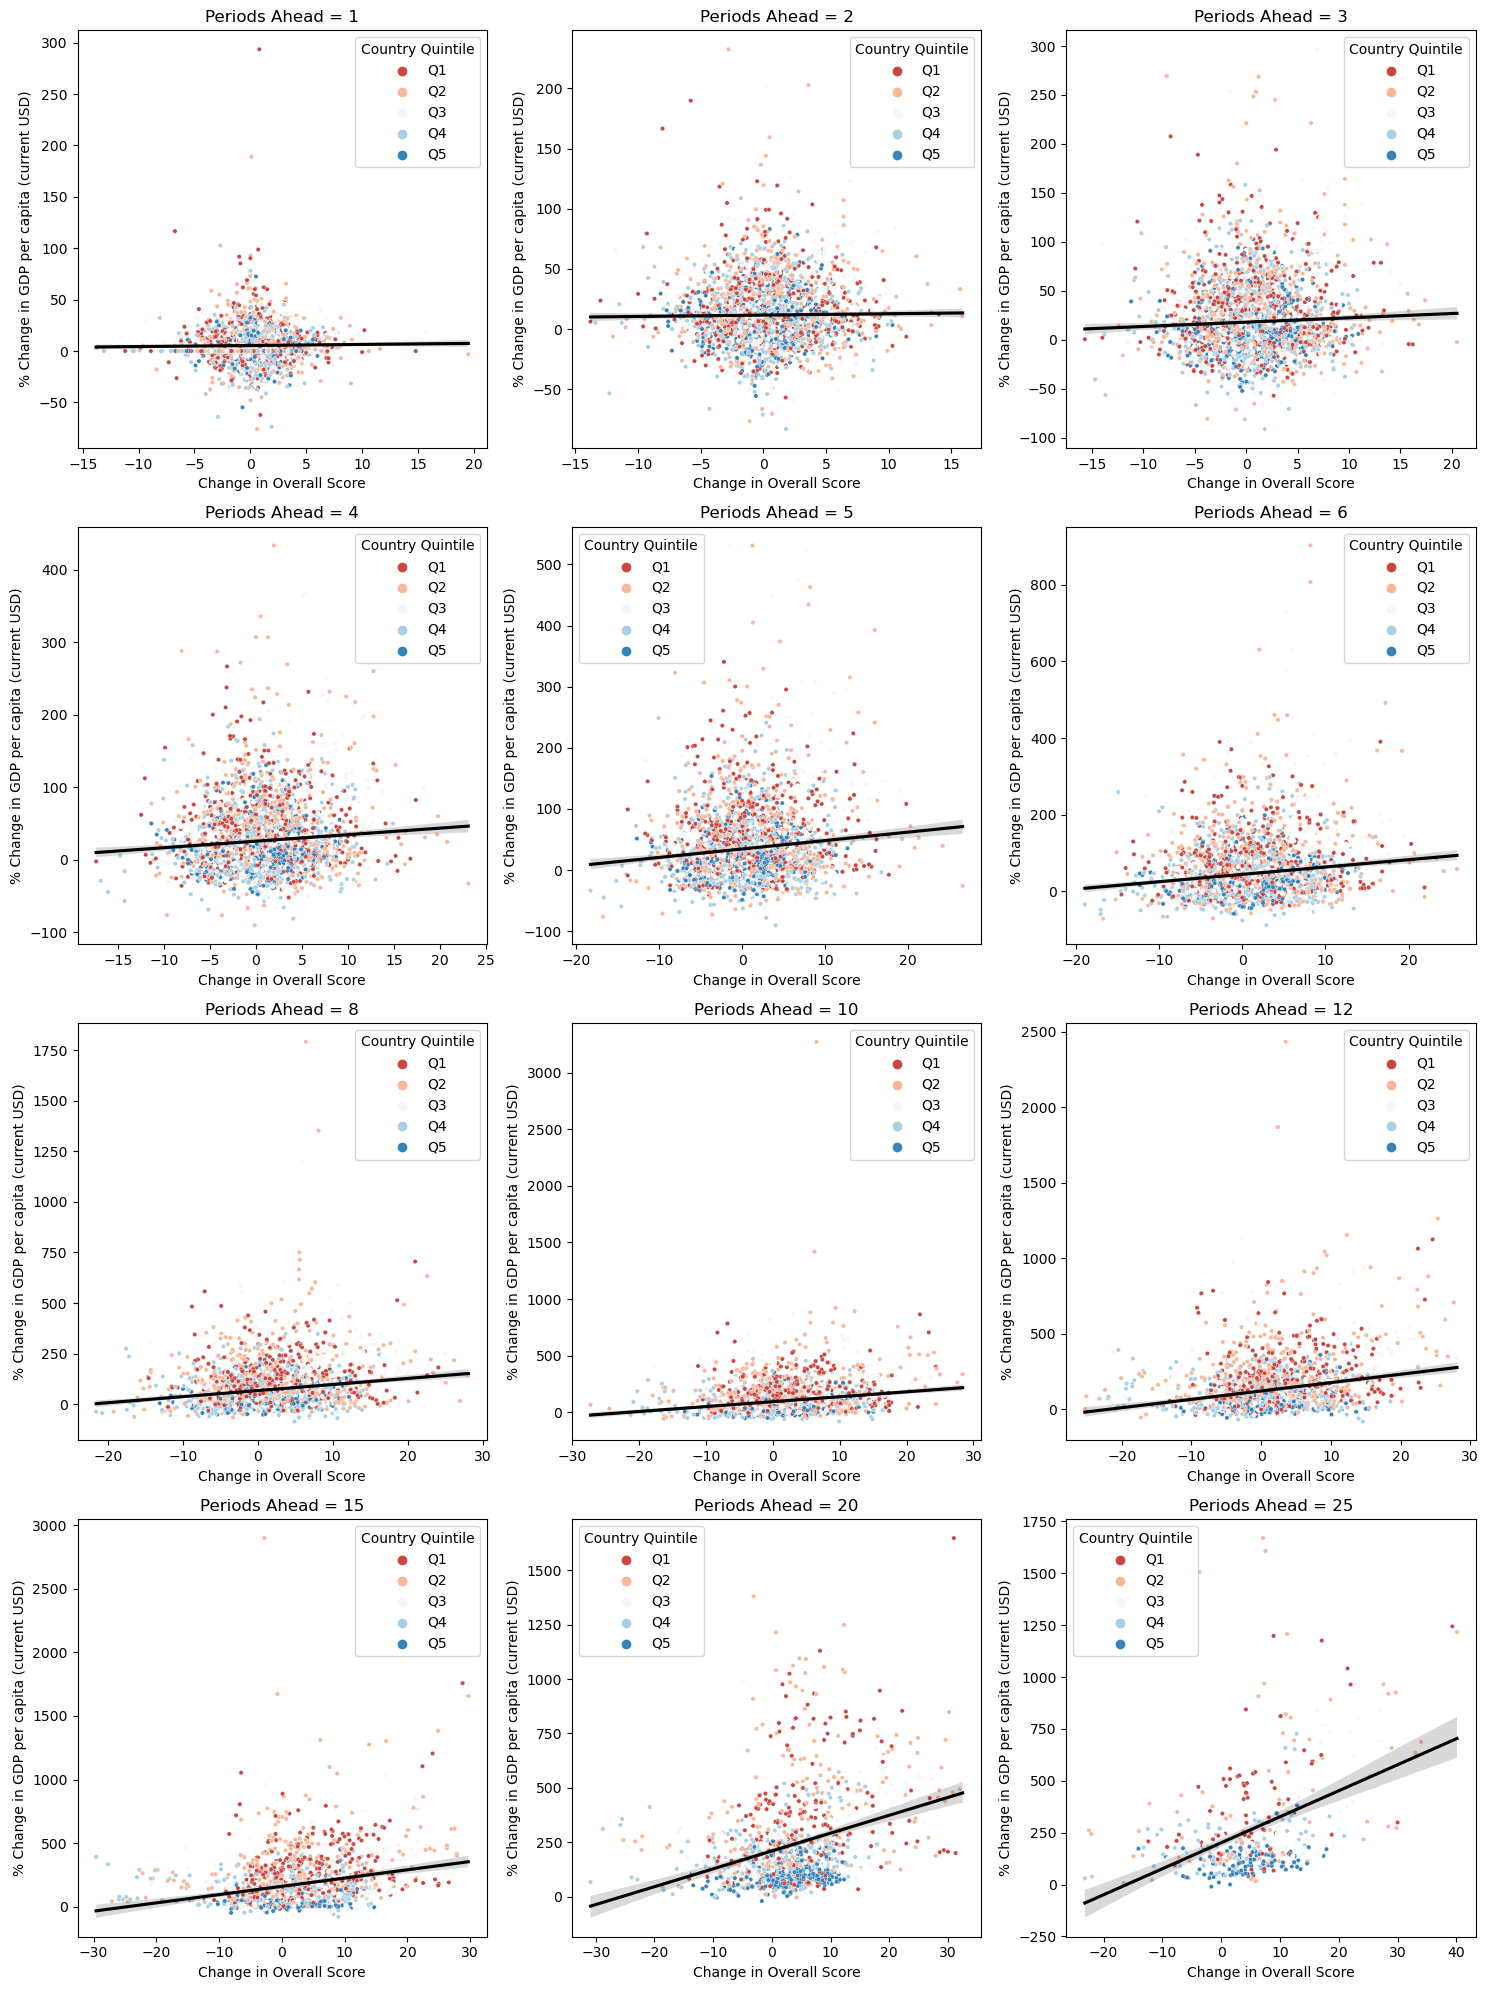




## Rule of Law: Results


Years Ahead  Coefficient (target to predictor % Change)   Intercept  \
0             1                                   -0.041007    5.350233   
1             2                                   -0.092354   11.490668   
2             3                                   -0.276269   18.106385   
3             4                                   -0.427328   26.295109   
4             5                                   -0.535609   35.875925   
5             6                                   -0.667984   46.464836   
6             8                                   -0.956934   71.249353   
7            10                                   -1.017348  100.761370   
8            12                                   -0.882862  131.635265   
9            15                                    0.440198  175.759565   
10           20                                    4.621120  229.543439   
11           25                                    6.520672  245.002021   

    R^2 Score  
0    0.000149  
1    0.000522  
2    0.003347  
3    0.005740  
4    0.006783  
5    0.007829  
6    0.009477  
7    0.007027  
8    0.004458  
9    0.000939  
10   0.093485  
11   0.141803

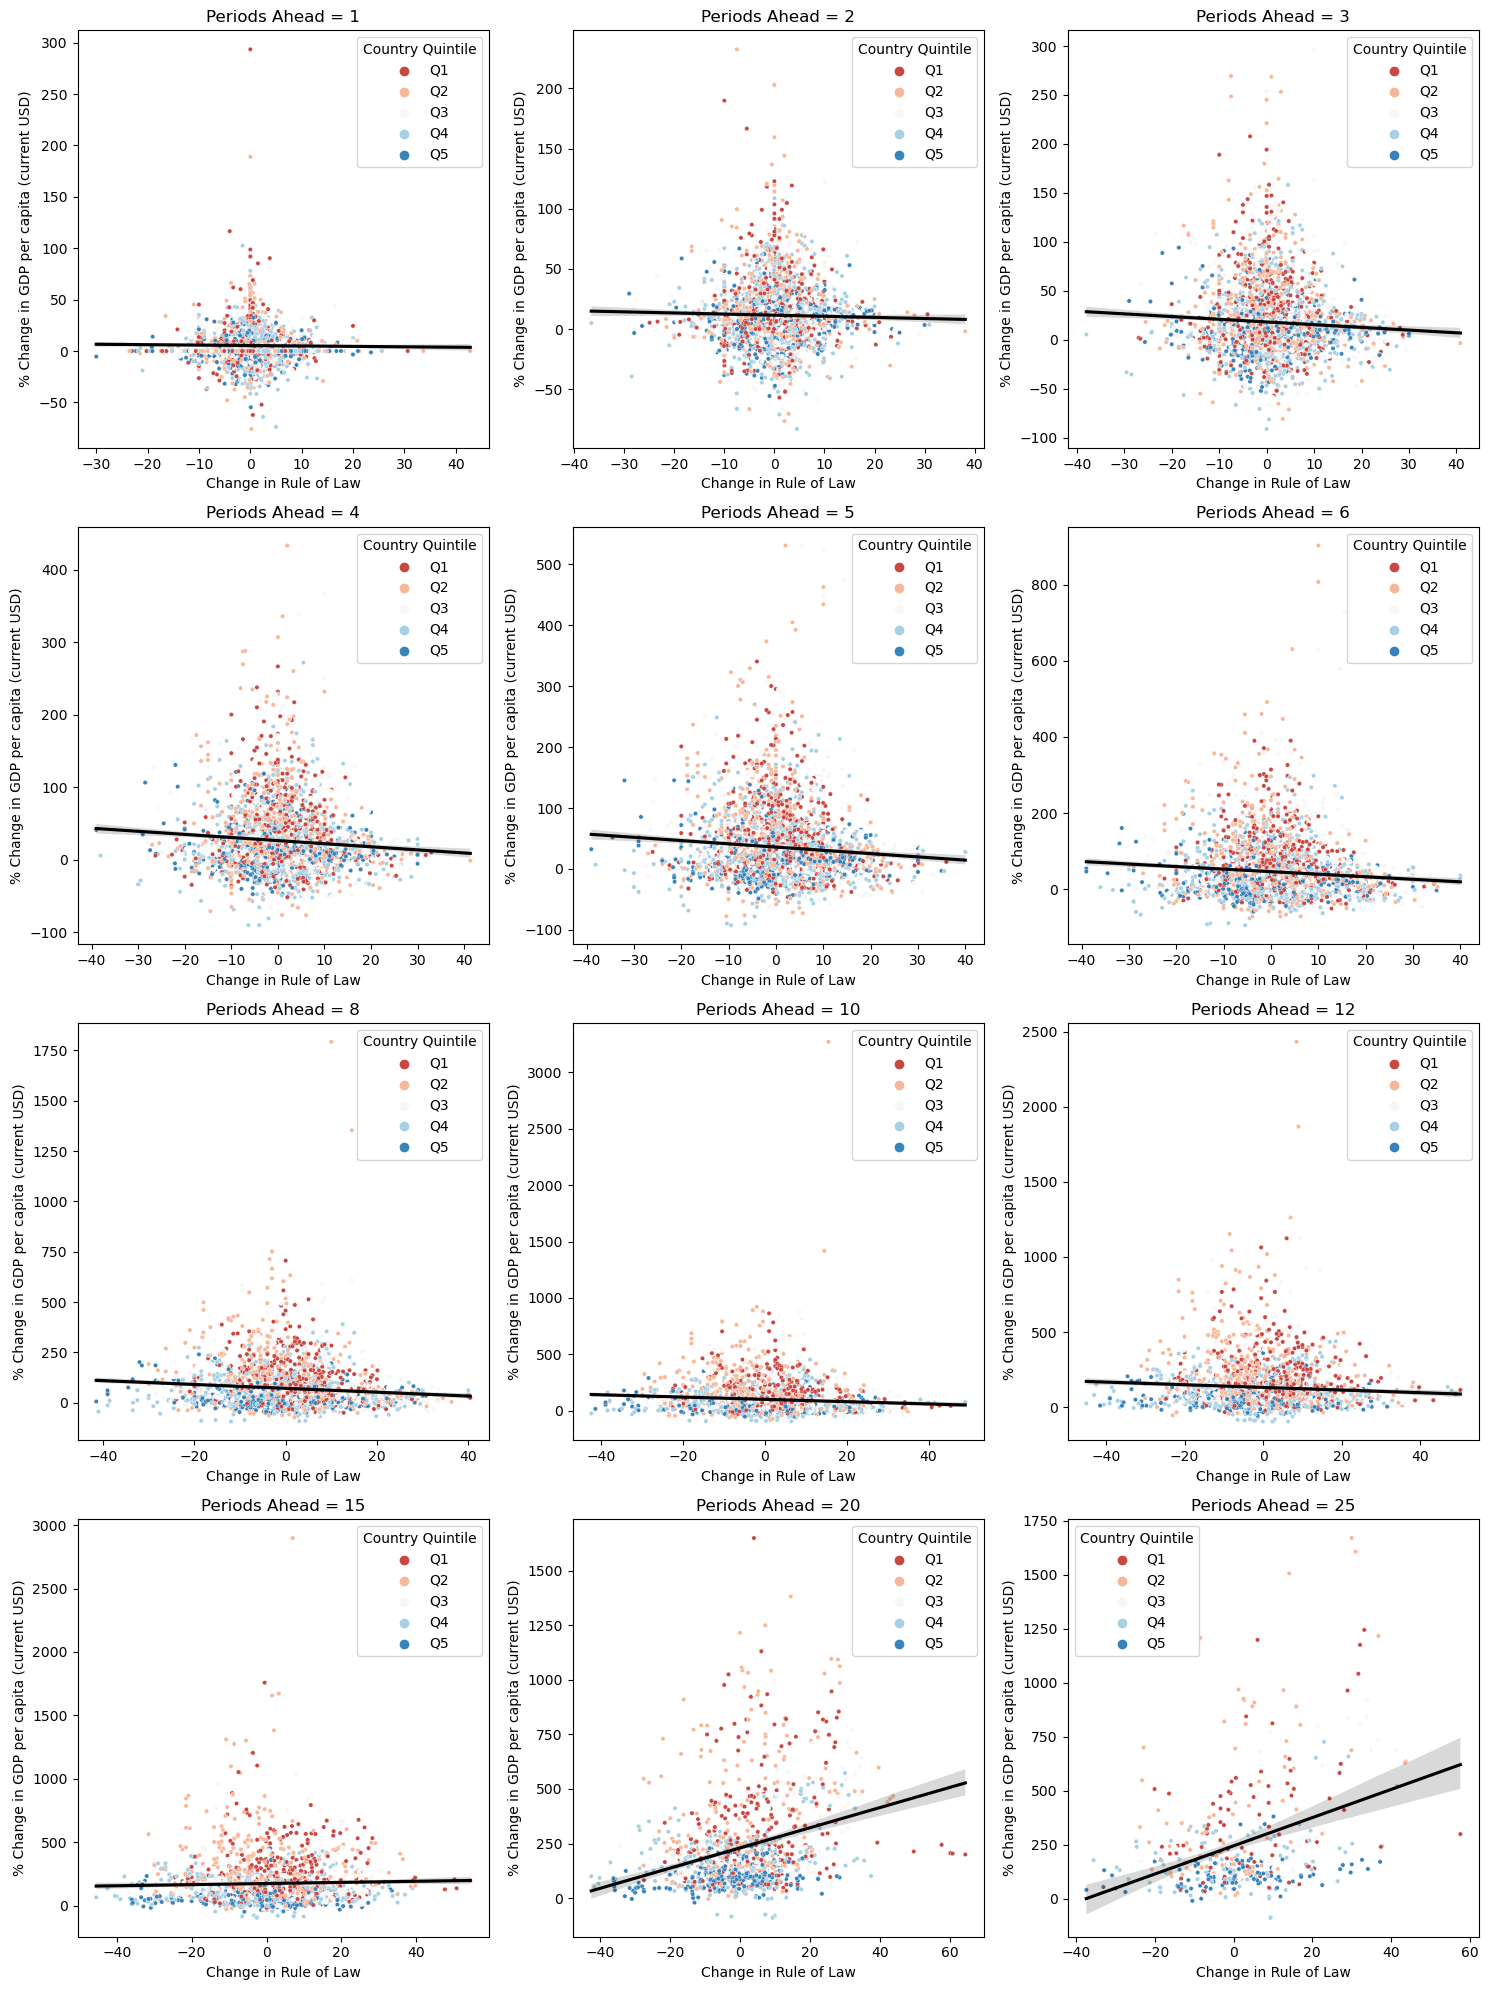




## Limited Government: Results


Years Ahead  Coefficient (target to predictor % Change)   Intercept  \
0             1                                    0.108057    5.348312   
1             2                                    0.074010   11.459612   
2             3                                    0.154444   17.907718   
3             4                                    0.313281   25.816982   
4             5                                    0.498145   35.045692   
5             6                                    0.705084   45.153680   
6             8                                    1.070488   69.149615   
7            10                                    1.377233   98.057404   
8            12                                    1.623668  128.475205   
9            15                                    1.547086  172.993317   
10           20                                    1.332031  231.420845   
11           25                                    2.512486  245.910078   

    R^2 Score  
0    0.001580  
1    0.000588  
2    0.001847  
3    0.005223  
4    0.009160  
5    0.012585  
6    0.015741  
7    0.016175  
8    0.018879  
9    0.013660  
10   0.011900  
11   0.034805

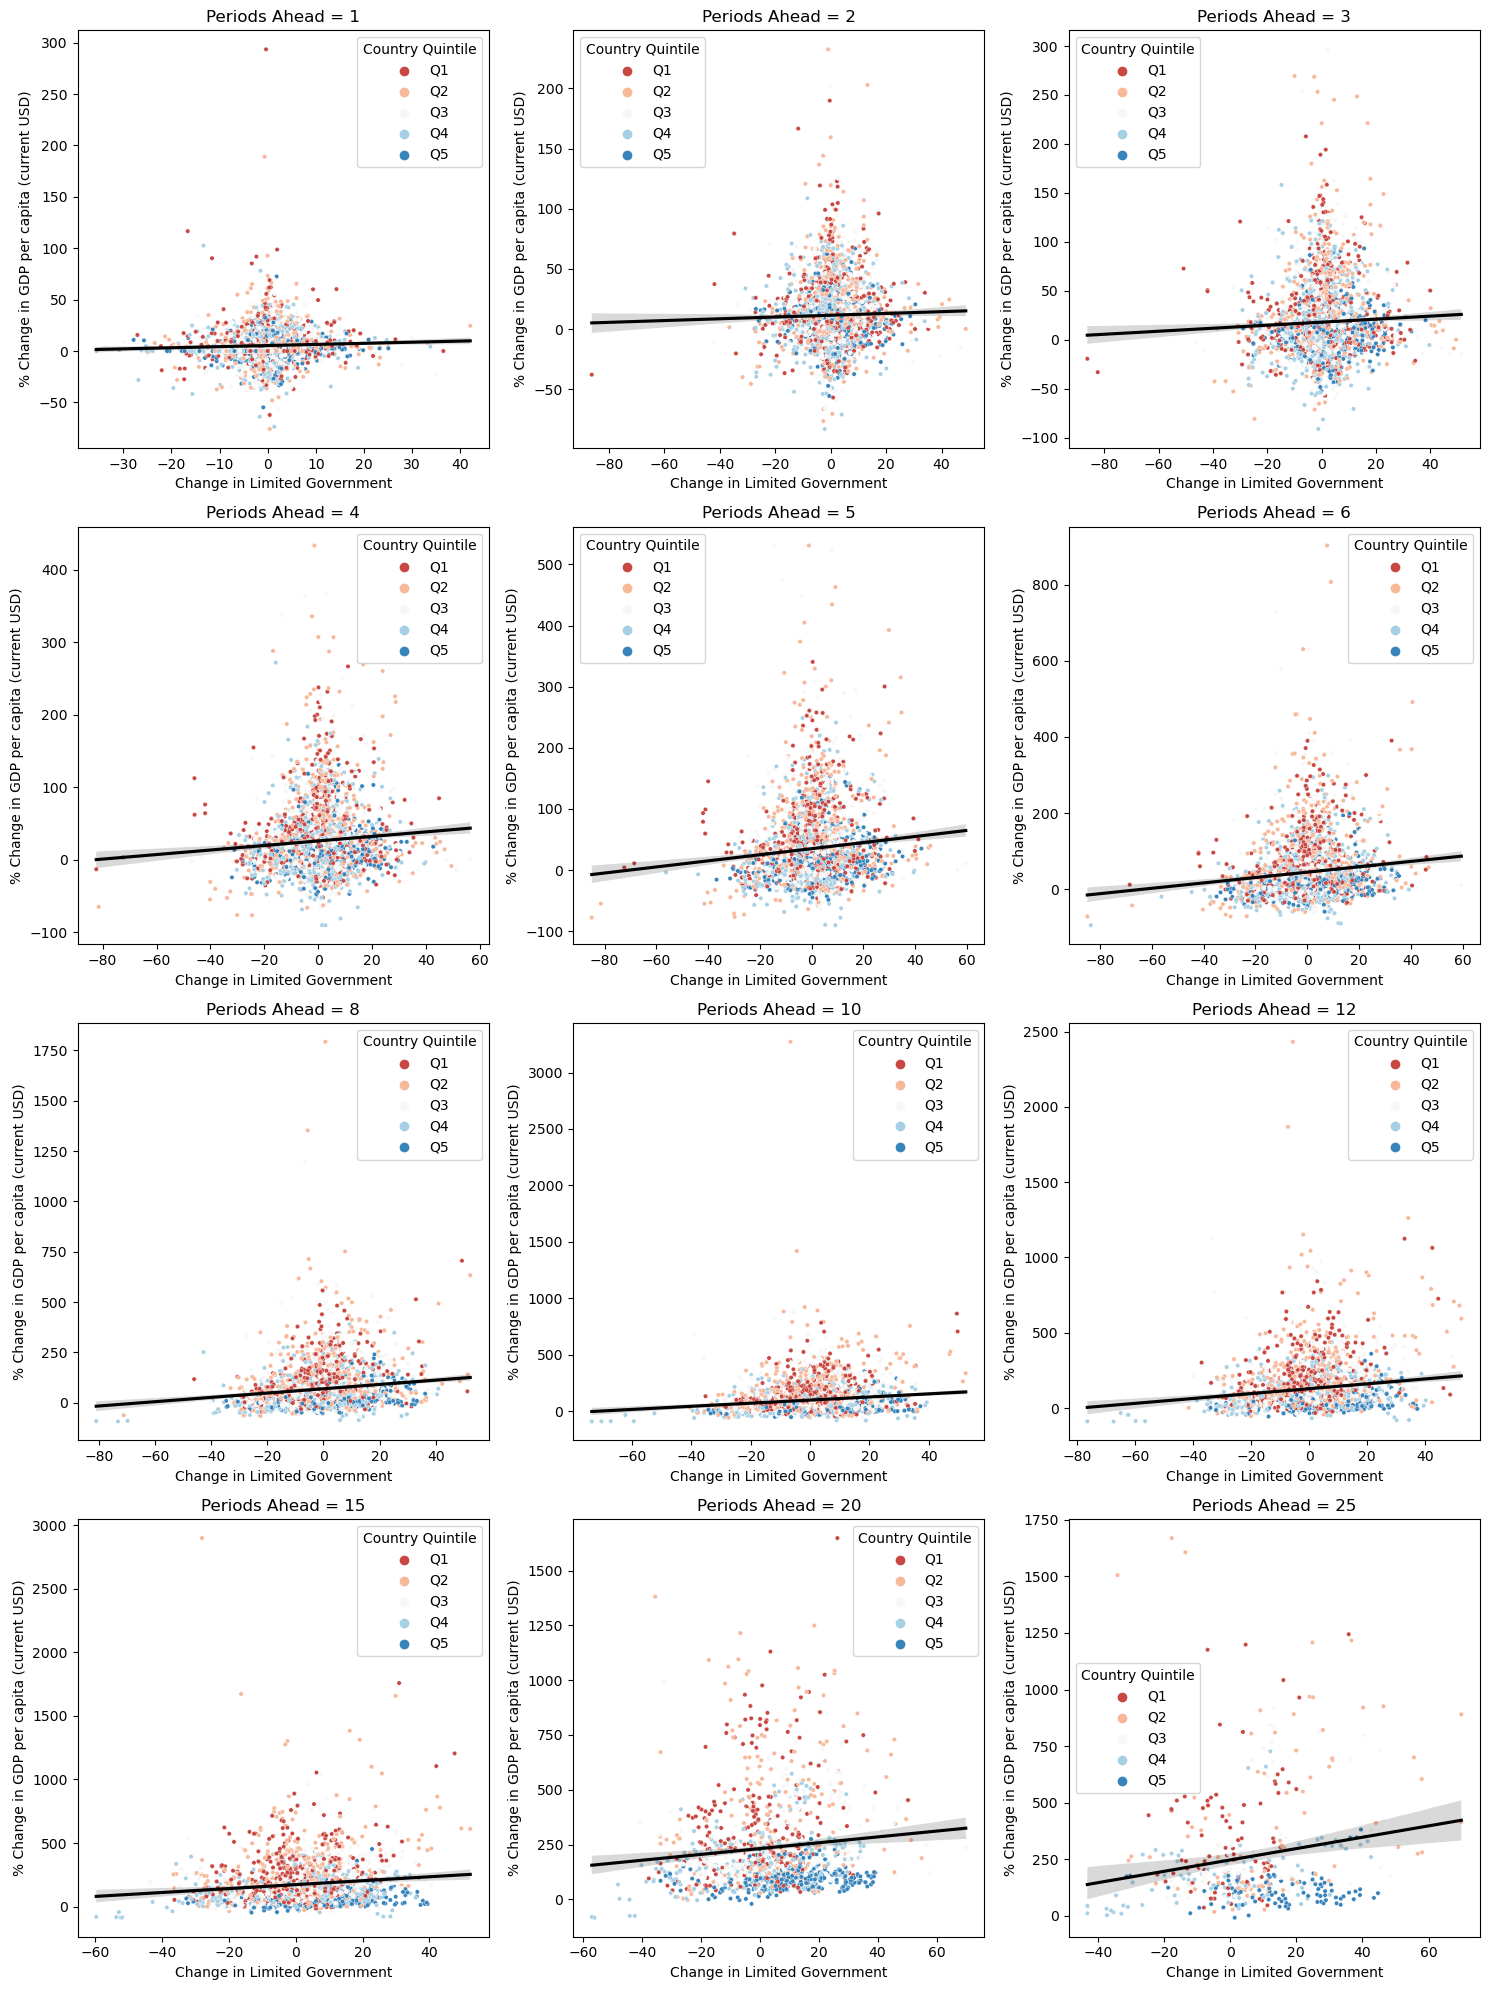




## Regulatory Efficiency: Results


Years Ahead  Coefficient (target to predictor % Change)   Intercept  \
0             1                                   -0.090141    5.344259   
1             2                                   -0.215744   11.495175   
2             3                                   -0.026758   17.977636   
3             4                                    0.134517   26.003395   
4             5                                    0.381452   35.372721   
5             6                                    0.732440   45.689707   
6             8                                    1.829682   70.237694   
7            10                                    3.215625  100.116827   
8            12                                    4.530688  131.091398   
9            15                                    5.808820  175.191592   
10           20                                    6.186490  231.584719   
11           25                                    8.859245  240.773877   

    R^2 Score  
0    0.000521  
1    0.002341  
2    0.000027  
3    0.000491  
4    0.002868  
5    0.007666  
6    0.028640  
7    0.059093  
8    0.099431  
9    0.144183  
10   0.169752  
11   0.283708

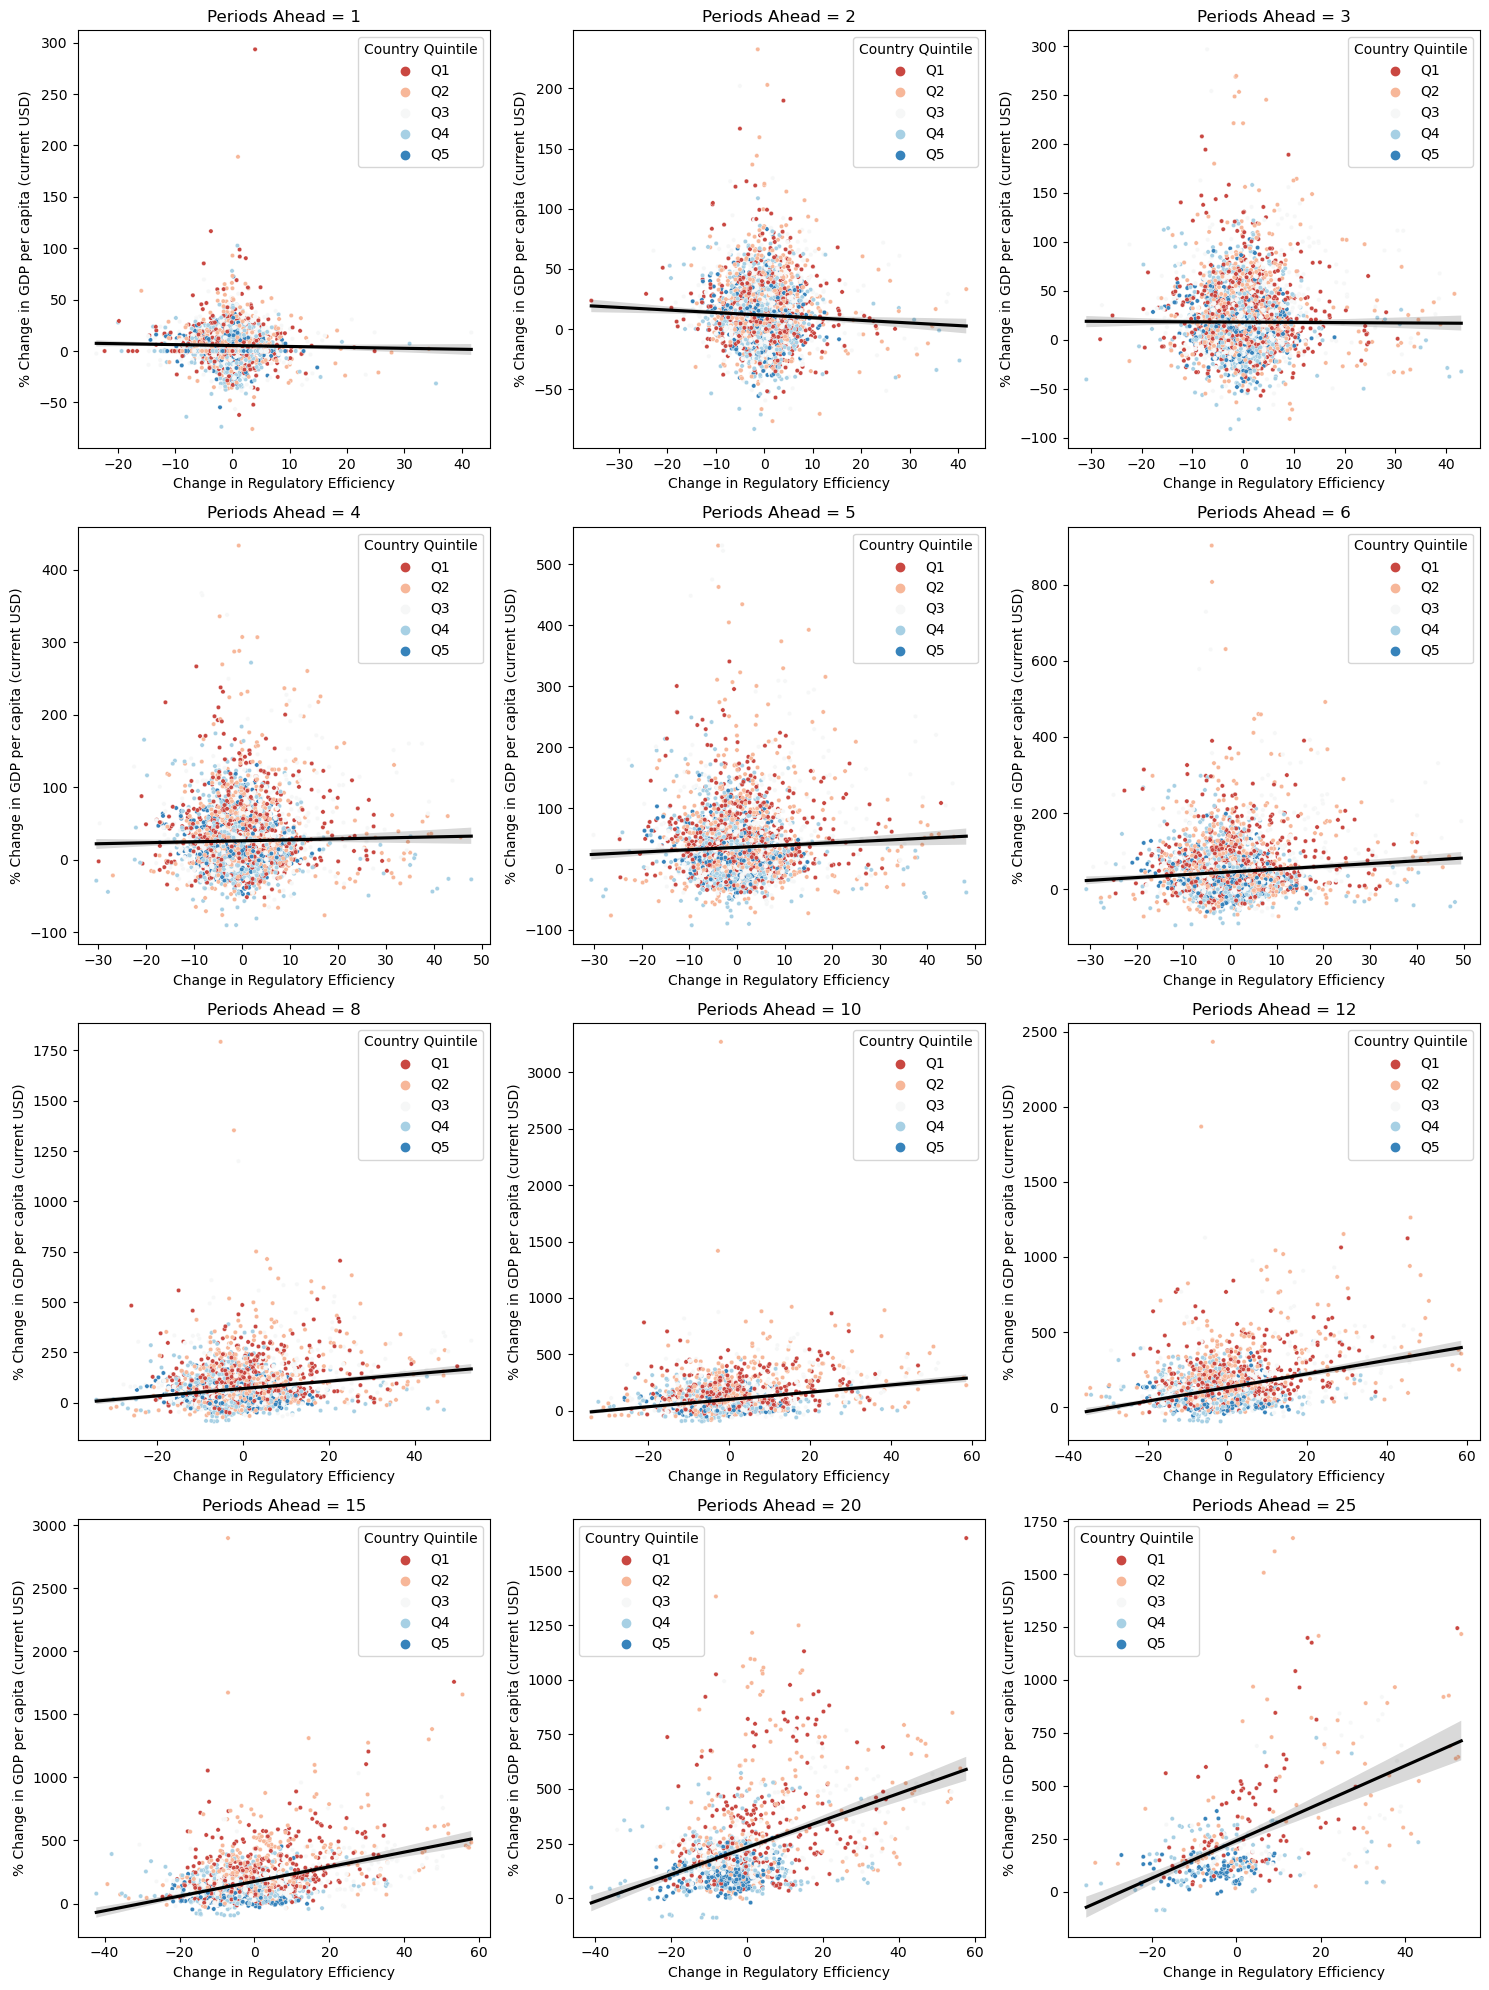




## Open Markets: Results


Years Ahead  Coefficient (target to predictor % Change)   Intercept  \
0             1                                    0.033618    5.336562   
1             2                                    0.157380   11.383726   
2             3                                    0.320301   17.712861   
3             4                                    0.461429   25.514397   
4             5                                    0.574193   34.596198   
5             6                                    0.738499   44.439604   
6             8                                    1.124964   67.425162   
7            10                                    1.315825   95.592051   
8            12                                    1.294679  125.709006   
9            15                                    0.917235  170.905218   
10           20                                    0.813351  229.183672   
11           25                                    4.331501  229.864638   

    R^2 Score  
0    0.000068  
1    0.001058  
2    0.003099  
3    0.004577  
4    0.005138  
5    0.006221  
6    0.008392  
7    0.007205  
8    0.005591  
9    0.002359  
10   0.001596  
11   0.031009

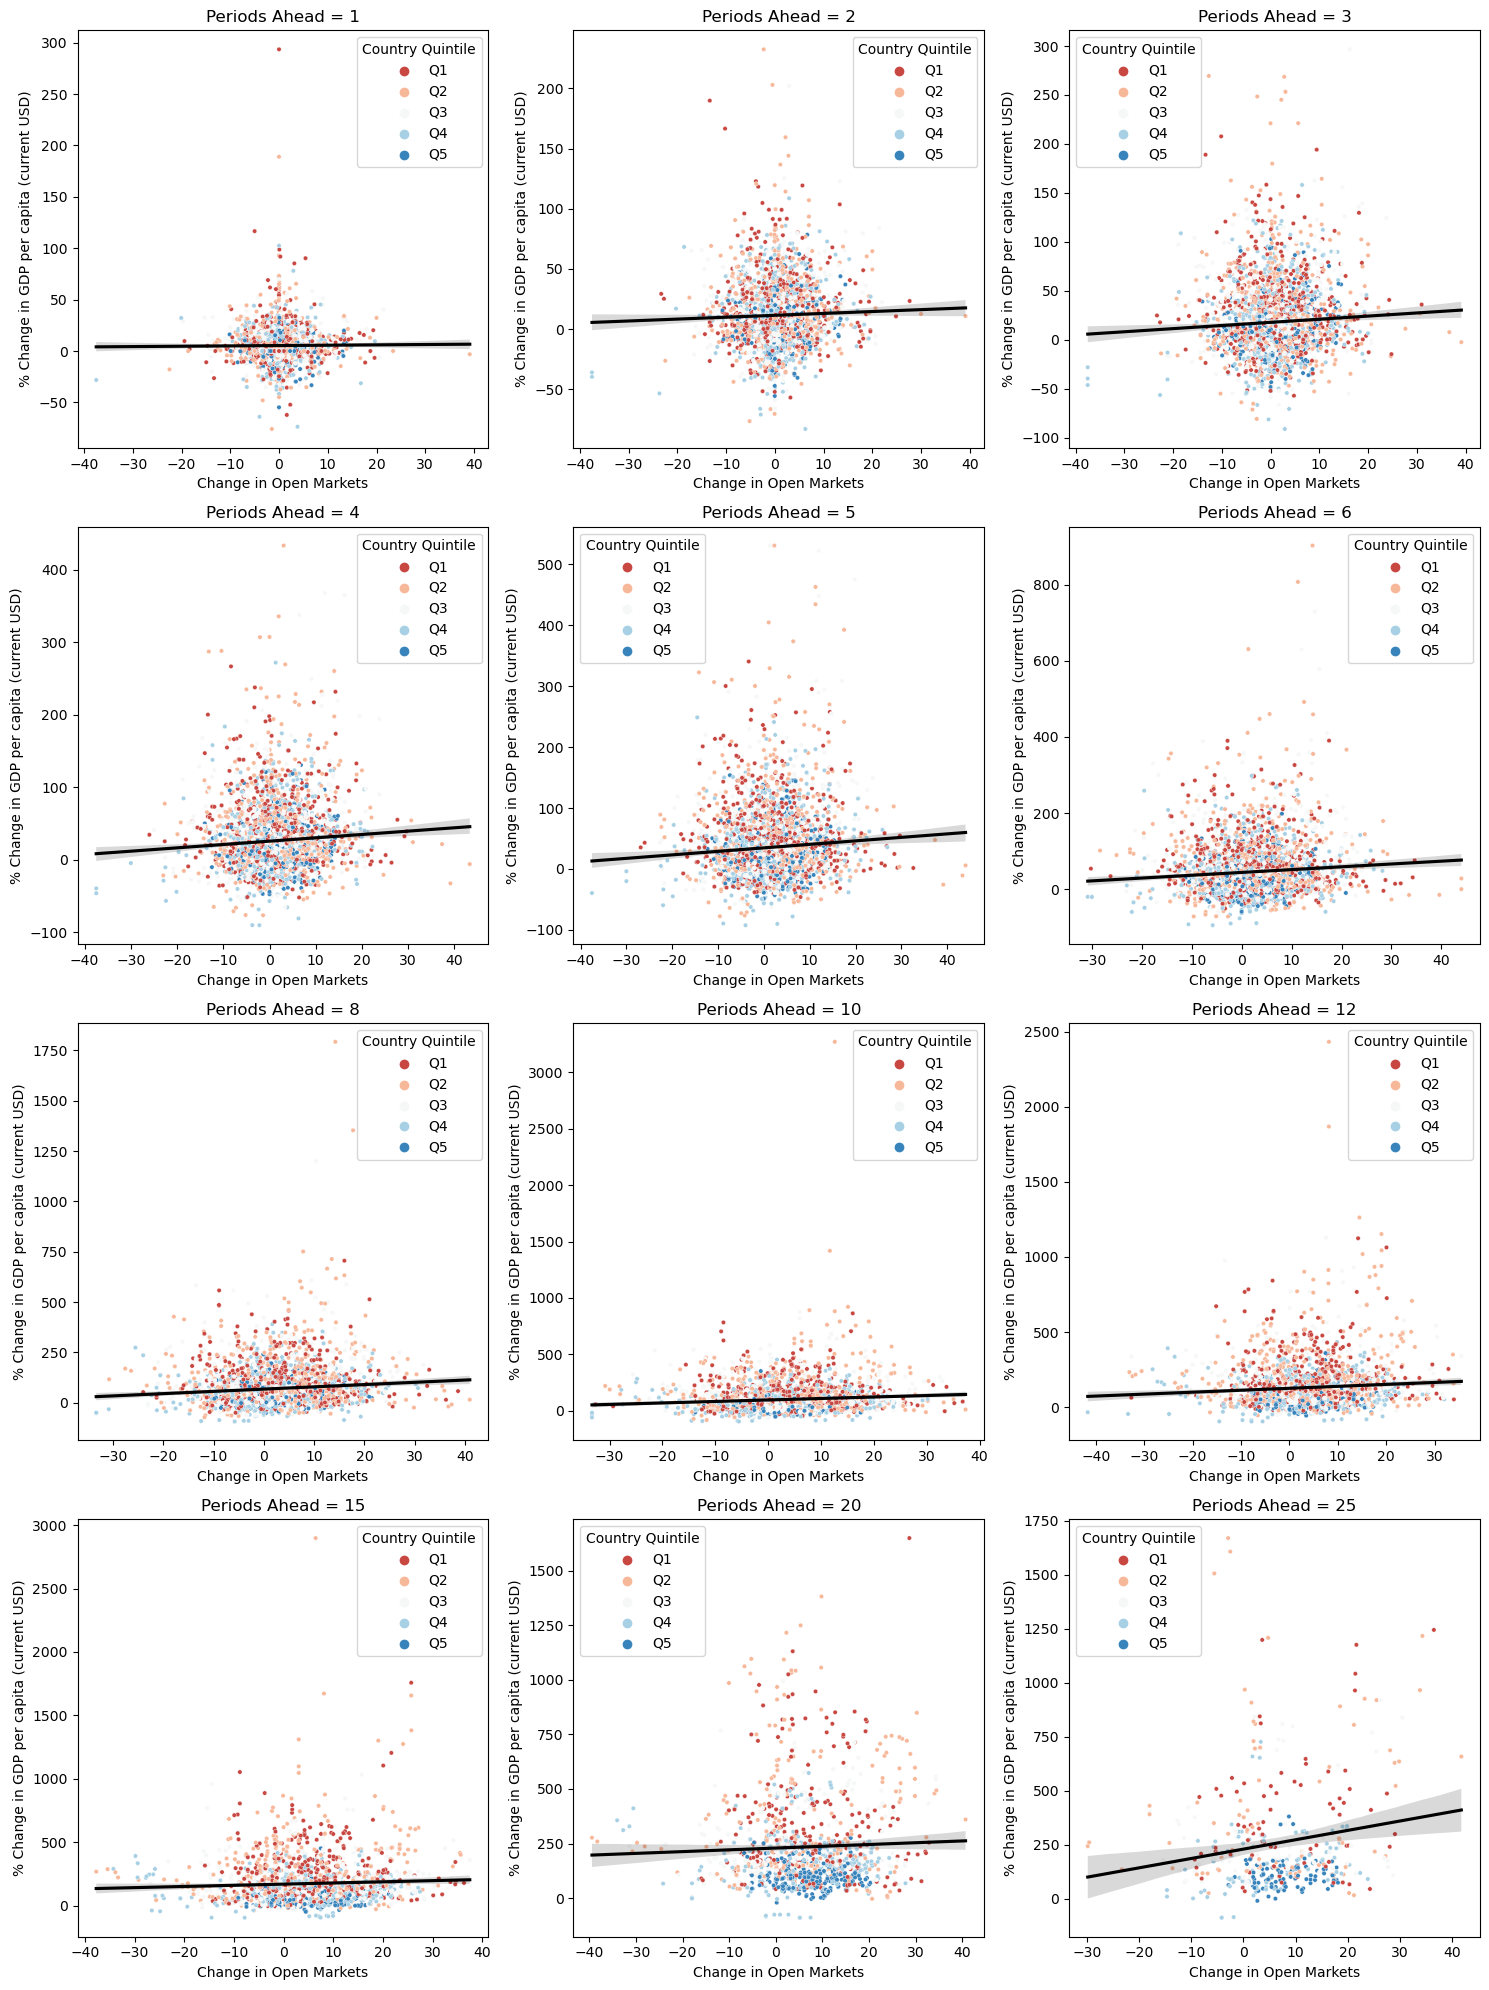

In [8]:
# Create an empty DataFrame to store coefficients and R^2 scores for year 6
summaryData = pd.DataFrame(columns=['Predictor', 'Coefficient (Year 6)', 'R^2 Score (Year 6)'])

# Loop through each predictor
for predictor in predictors:
    print(f"## {predictor}: Results")
  
    regression_results, df_withDeltas = TimeSeriesGrowthAnalysis(df_base, timePeriods_delta=years_delta, predictor=predictor)
    
    # Extract the coefficient and R^2 score for year 6 
    year6_data = regression_results[regression_results['Years Ahead'] == 6]
    coeff_for_year6 = year6_data['Coefficient (target to predictor % Change)'].values[0]
    r2_for_year6 = year6_data['R^2 Score'].values[0]
    
    # Append to the DataFrame
    new_row = pd.DataFrame({
        'Predictor': [predictor], 
        'Coefficient (Year 6)': [coeff_for_year6],
        'R^2 Score (Year 6)': [r2_for_year6]
    })
    summaryData = pd.concat([summaryData, new_row], ignore_index=True)
    
    # Display regression results
    display(regression_results)
    
    # Plot the analysis
    PlotTimeSeriesGrowthAnalysis(df_withDeltas, timePeriods_delta=years_delta, predictor=predictor)
    print("\n\n")


In [9]:
summaryData.sort_values(by='R^2 Score (Year 6)')

Predictor  Coefficient (Year 6)  R^2 Score (Year 6)
4           Open Markets              0.738499            0.006221
3  Regulatory Efficiency              0.732440            0.007666
1            Rule of Law             -0.667984            0.007829
2     Limited Government              0.705084            0.012585
0          Overall Score              1.919177            0.018448